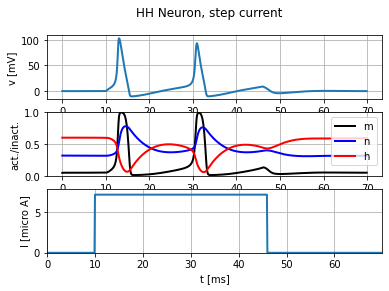

In [1]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
from neurodynex3.hodgkin_huxley import HH
from neurodynex3.tools import input_factory

HH.getting_started()

In [4]:
def plot_data(state_monitor, title=None):
    """Plots the state_monitor variables ["vm", "I_e", "m", "n", "h"] vs. time.

    Args:
        state_monitor (StateMonitor): the data to plot
        title (string, optional): plot title to display
    """

    plt.subplot(311)
    plt.plot(state_monitor.t / b2.ms, state_monitor.vm[0] / b2.mV, lw=2)

    plt.xlabel("t [ms]")
    plt.ylabel("v [mV]")
    plt.grid()

    plt.subplot(312)

    plt.plot(state_monitor.t / b2.ms, state_monitor.m[0] / b2.volt, "black", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.n[0] / b2.volt, "blue", lw=2)
    plt.plot(state_monitor.t / b2.ms, state_monitor.h[0] / b2.volt, "red", lw=2)
    plt.xlabel("t (ms)")
    plt.ylabel("act./inact.")
    plt.legend(("m", "n", "h"))
    plt.ylim((0, 1))
    plt.grid()

    plt.subplot(313)
    plt.plot(state_monitor.t / b2.ms, state_monitor.I_e[0] / b2.uamp, lw=2)
    plt.axis((
        0,
        np.max(state_monitor.t / b2.ms),
        min(state_monitor.I_e[0] / b2.uamp) * 1.1,
        max(state_monitor.I_e[0] / b2.uamp) * 1.1
    ))

    plt.xlabel("t [ms]")
    plt.ylabel("I [micro A]")
    plt.grid()

    if title is not None:
        plt.suptitle(title)

    plt.show()



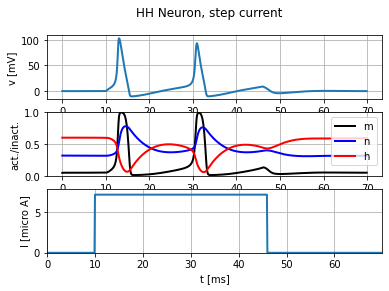

In [5]:
import brian2 as b2
import matplotlib.pyplot as plt
import numpy as np
import neurodynex3.tools.input_factory as input_factory



def simulate_HH_neuron(input_current, simulation_time):

    """A Hodgkin-Huxley neuron implemented in Brian2.

    Args:
        input_current (TimedArray): Input current injected into the HH neuron
        simulation_time (float): Simulation time [seconds]

    Returns:
        StateMonitor: Brian2 StateMonitor with recorded fields
        ["vm", "I_e", "m", "n", "h"]
    """

    # neuron parameters
    El = 10.6 * b2.mV
    EK = -12 * b2.mV
    ENa = 115 * b2.mV
    gl = 0.3 * b2.msiemens
    gK = 36 * b2.msiemens
    gNa = 120 * b2.msiemens
    C = 1 * b2.ufarad

    # forming HH model with differential equations
    eqs = """
    I_e = input_current(t,i) : amp
    membrane_Im = I_e + gNa*m**3*h*(ENa-vm) + \
        gl*(El-vm) + gK*n**4*(EK-vm) : amp
    alphah = .07*exp(-.05*vm/mV)/ms    : Hz
    alpham = .1*(25*mV-vm)/(exp(2.5-.1*vm/mV)-1)/mV/ms : Hz
    alphan = .01*(10*mV-vm)/(exp(1-.1*vm/mV)-1)/mV/ms : Hz
    betah = 1./(1+exp(3.-.1*vm/mV))/ms : Hz
    betam = 4*exp(-.0556*vm/mV)/ms : Hz
    betan = .125*exp(-.0125*vm/mV)/ms : Hz
    dh/dt = alphah*(1-h)-betah*h : 1
    dm/dt = alpham*(1-m)-betam*m : 1
    dn/dt = alphan*(1-n)-betan*n : 1
    dvm/dt = membrane_Im/C : volt
    """

    neuron = b2.NeuronGroup(1, eqs, method="exponential_euler")

    # parameter initialization
    neuron.vm = 0
    neuron.m = 0.05
    neuron.h = 0.60
    neuron.n = 0.32

    # tracking parameters
    st_mon = b2.StateMonitor(neuron, ["vm", "I_e", "m", "n", "h"], record=True)

    # running the simulation
    hh_net = b2.Network(neuron)
    hh_net.add(st_mon)
    hh_net.run(simulation_time)

    return st_mon

current = input_factory.get_step_current(10, 45, b2.ms, 7.2 * b2.uA)
state_monitor = simulate_HH_neuron(current, 70 * b2.ms)
plot_data(state_monitor, title="HH Neuron, step current")
